In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import matplotlib.animation as animation

### Hexagonal Grids

Hexagonal grids offer the simplest solution to smoothing a grid. Each hexagon is adjacent to hexagons with shared edges, instead of shared vertices as with the 8-neighbor square grid. As such, each cell has 6 neighors instead of 8. Although each cell has fewer neighbors, a cell's neighbors are all equidistant from itself.  

This example will take advantage of matplotlib's hexbin function, which allows for easy plotting of hexagonal grids. However, its function signature operates quite differently from matplotlib.imshow. 

matplotlib.pyplot.hexbin(x, y, C, gridsize)

x - array of the x coordinates of hexagons

y - array of the y coordinates of the hexagons

C - array of hexagon states. For example, C[i] 
    corresponds to the state of the grid at 
    (x[i], y[i])
    
gridsize - tuple of the number of hexagons in the x and y direction  

This example is going to show a wave propagating through the grid network, which requires maintaining
two key variables of each hexagon: its state and its cooldown. In order for a wave to properly propagate,
it must have some sort of delay before it can activate again, which will be referred to as its cooldown. A hexagon
can only activate once its cooldown time has decremented to zero. For example, if a hexagon has a cooldown time
of 5, it can only activate again once 5 frames have passed since the previous activation. In this way, the waves 
propagate outwards without propagating back inwards. 

In [2]:
# This function generates the positions of the hexagons for the hexagonal grid.
# Every even row has grid_width number of hexagons, and every odd row has
# grid_width - 1 hexagons. The odd rows are offset from the even rows by 
# half the width of a hexagon, because that's how geometry works. 
def gen_hex_grid(grid_width):
    grid_width = grid_width if grid_width % 2 == 1 else grid_width + 1
    start = -grid_width / 2.0 + 1 / 2
    end = grid_width / 2 - 1/2
    
    x_even = np.linspace(start, end, grid_width)
    x_odd = np.linspace(start + 1/2, end - 1/2, grid_width - 1)
    
    y_values = np.linspace(start, end, grid_width)
    
    x = []
    y = []
    
    for i in range(grid_width):
        curr_y = y_values[i]
        if (i % 2 == 0) :
            x += list(x_even)
            y += [curr_y for j in range(grid_width)]
        else:
            x += list(x_odd)
            y += [curr_y for j in range(grid_width - 1)]
        
    plot_hex(x,y)
    return x, y

In [3]:
# This function plots the hexagonal grid for your viewing pleasure
def plot_hex(x, y):
    C = [i for i in range(len(x))]
    
    fig, ax = plt.subplots(figsize = (6,6))
    ax.set_ylim(-grid_width / 2 - 1, grid_width / 2 + 1)
    ax.set_xlim(-grid_width / 2 - 1, grid_width / 2 + 1)
    mat = ax.hexbin(x, y, C = C, gridsize = (grid_width - 1, int(grid_width / 2)))
    plt.show()

In [4]:
# This function  determines which hexagons are adjacent to one another.
# The logic looks really gross just because it has to account for
# the edges of the grid, and because the logic is different for even and odd rows
# I think this structure does a few more comparisons than is necessary,
# but its a little more readable this way
def gen_adj_dict(grid_width):
    grid_width = grid_width if grid_width % 2 == 1 else grid_width + 1 
    index = 0
    adj_dict = {}
    
    for y in range(grid_width):
        # whether the hexagon is on an even or odd row
        even_row = y % 2 == 0 

        # the number of hexagons in the current row
        x_count = grid_width if even_row else grid_width - 1

        # whether the hexagon is on a y-axis edge
        bottom_edge = y == 0
        top_edge = y == grid_width - 1
        
        for x in range(x_count):
            # whether the hexagon is on an x-axis edge
            left_edge = x == 0
            right_edge = x == x_count - 1 
            
            # the indices of a hexagon's spatially 
            # adjacent hexagons, if they exist
            right_hex = index + 1
            left_hex = index - 1
            upper_right = index + grid_width
            upper_left = index + grid_width - 1
            lower_right = index - grid_width
            lower_left = index - grid_width + 1
           
            adj_dict[index] = []
            
            # logic for adjacency to the right
            if not right_edge: 
                adj_dict[index].append(right_hex)
                
            # logic for adjacency to the left
            if not left_edge:
                adj_dict[index].append(left_hex)
                
            # logic for the y-axis adjacency of even rows
            if even_row:
                if not top_edge:
                    if not right_edge:
                        adj_dict[index].append(upper_right)
                    if not left_edge: 
                        adj_dict[index].append(upper_left)
                if not bottom_edge:
                    if not left_edge: 
                        adj_dict[index].append(lower_right)
                    if not right_edge:
                        adj_dict[index].append(lower_left)
                
            # logic for the y-axis adjacency of odd rows
            else: 
                if not top_edge:
                    adj_dict[index].append(upper_right)
                    adj_dict[index].append(upper_left)
                if not bottom_edge:
                    adj_dict[index].append(lower_right)
                    adj_dict[index].append(lower_left)
            
            index += 1
    return adj_dict
    

In [7]:
# these are the parameters for the animation!

# a couple notes:
# - grid_width must be odd, because of the way
#   hexbin treats the center of each hexagon
#
# - if delay is less than 3, back propogation will occur. Try it!
#
# - beat_rate = (grid_width + delay) will guarantee that 
#   each wave won't be interferred with. Changing it 
#   to small value ( < 10) leads to some really interesting animations!
#
# - feel free to change the seed hexagon


grid_width = 17 # number of hexagons in each axis
delay = 3 # cooldown time of each hexagon
beat_rate = (grid_width + delay) # how often a new wave is initiated
seed = int(.5 * grid_width ** 2) # the starting hexagon

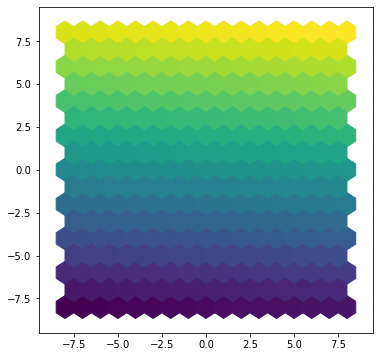

In [8]:
ON = 255
OFF = 0

adj_dict = gen_adj_dict(grid_width)
x, y = gen_hex_grid(grid_width)
hex_count = len(x)

hex_state = [OFF for i in range(hex_count)]
hex_cooldown= {i : 0 for i in range(hex_count)}


def init():
    hex_cooldown[seed] = delay
    hex_state[seed] = ON
    return ax.hexbin(x, y, C = hex_state, gridsize = (grid_width - 1, int(grid_width / 2)), cmap = "summer")
        
def update(data):
    
    # decrements the cooldown of all hexagons by one
    for hexagon in hex_cooldown:
        if hex_cooldown[hexagon] > 0:
            hex_cooldown[hexagon] -= 1
    
    # creates a snap shot of the current state
    # and uses it to compute the next state
    hex_state_copy = hex_state.copy()
    for hexagon in range(hex_count):
        
        # if a hexagon has been activated
        if hex_state_copy[hexagon] == ON:            
            # activate its neighbors, if they aren't cooling down
            for neighbor in adj_dict[hexagon]:
                if hex_cooldown[neighbor] == 0: 
                    hex_cooldown[neighbor] = delay
                    hex_state[neighbor] = ON
            # deactivate that hexagon
            hex_state[hexagon] = OFF
    
    # reignites a random hexagon one every beat_rate frames
    if (data + 1) % beat_rate == 0:
        beat_hex = int(random.random() * hex_count)
        hex_state[beat_hex] = ON
        hex_cooldown[beat_hex] = delay

    # Completely recreates the plot with each frame.
    # It isn't possible to simply redraw the plot because
    # hexbin doesn't support that functionality
    return  ax.hexbin(x, y, C = hex_state, gridsize = (grid_width - 1, int(grid_width / 2)), cmap = "summer")

fig, ax = plt.subplots(figsize = (6,6))
ax.set_ylim(-grid_width / 2 - 1, grid_width / 2 + 1)
ax.set_xlim(-grid_width / 2 - 1, grid_width / 2 + 1)
mat = ax.hexbin(x, y, C = hex_state, gridsize = (grid_width - 1, int(grid_width / 2)), cmap = "summer")
ani = animation.FuncAnimation(fig, update, interval = 50, save_count = 50, init_func = init)
plt.close(fig)

from IPython.display import HTML
HTML(ani.to_jshtml())